## Use Case: Improving Forecasting Models for Diverse Time Series

Imagine you're a data scientist participating in the M4 forecasting competition. Your tasks:
- Forecast diverse monthly time series for the next 18 months
- Provide reliable confidence intervals for these forecasts
- Assess the impact of different bootstrapping methods on forecast accuracy

Challenge: The M4 dataset contains 48,000 diverse time series, each with different patterns, trends, and seasonality.

Solution: Use time series bootstrapping to generate multiple plausible futures, improving forecast accuracy and uncertainty estimation across various types of time series.

By the end of this notebook, you'll be able to:
1. Apply various bootstrapping techniques to diverse time series data
2. Generate robust forecasts with confidence intervals for different types of series
3. Compare the performance of different bootstrapping methods on forecast accuracy

Let's begin our journey into time series bootstrapping with the M4 monthly dataset!


## 1. Introduction to Time Series Bootstrapping and the M4 Dataset

### What is it?
- Resampling technique for time-dependent data
- Respects chronological order and correlations
- Unlike traditional bootstrapping (assumes independence)

### Why is it important for the M4 competition?
- Estimate uncertainty in forecasts
- Generate confidence intervals
- Simulate alternative scenarios
- Improve model robustness

### Challenges with traditional methods
- Underestimates long-term variability
- Loses temporal dependence structure
- Incorrect inference on trends/seasonality

In [1]:
import warnings
warnings.filterwarnings('ignore')

Run `convert_data.py` to conver the `.tsf` file to `.pkl` file

In [2]:
import os
import pandas as pd

# Get the current working directory
current_dir = os.getcwd()

# Go back one level
parent_dir = os.path.dirname(current_dir)

# Construct the path to the m4.pkl file
file_path = os.path.join(parent_dir, 'm4_monthly_dataset.pkl')

# Load the file
data = pd.read_pickle(file_path)

# Print the data to verify
print(data)

                         value
series_name date              
T1          1976-06-01  8000.0
            1976-07-01  8350.0
            1976-08-01  8570.0
            1976-09-01  7700.0
            1976-10-01  7080.0
...                        ...
T48000      2015-12-31  5020.0
            2016-01-31  4950.0
            2016-02-29  4860.0
            2016-03-31  5140.0
            2016-04-30  5100.0

[11246411 rows x 1 columns]


In [3]:
import matplotlib.pyplot as plt

# Set universal matplotlib rc parameters
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (12, 15)

Number of time series: 48000
Date range: 1790-01-01 00:00:00 to 2224-04-30 00:00:00
Average series length: 234.30 months


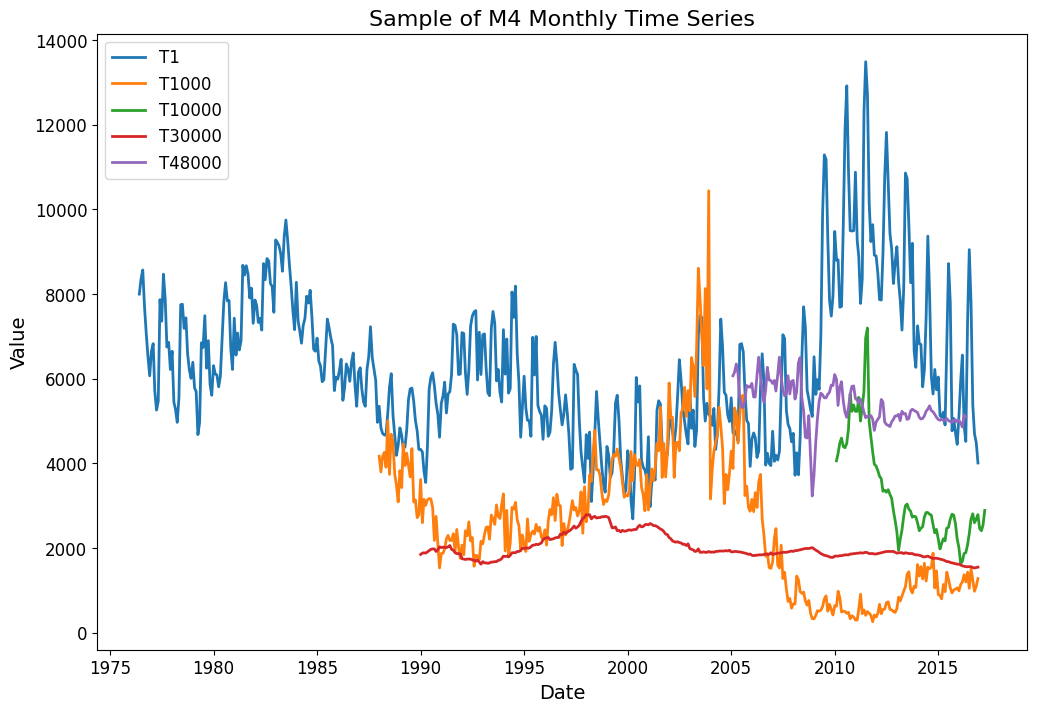

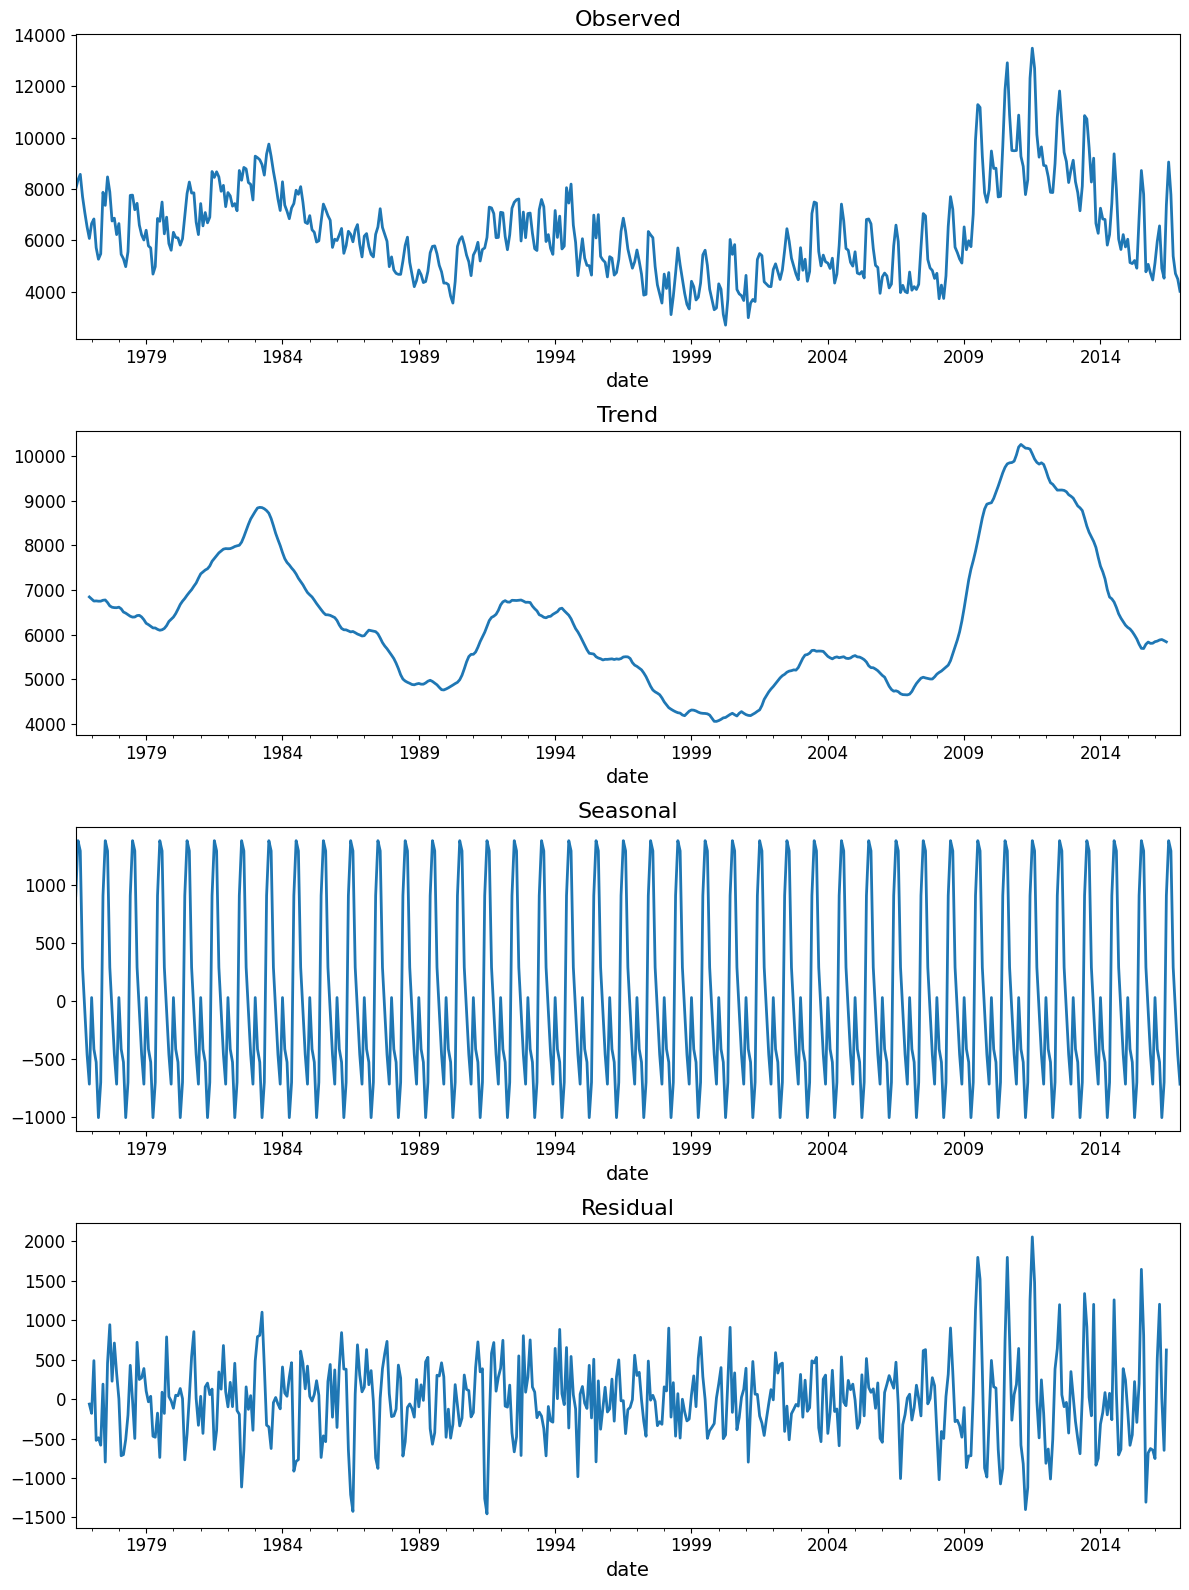

In [4]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Display basic information about the dataset
print(f"Number of time series: {
      data.index.get_level_values('series_name').nunique()}")
print(f"Date range: {data.index.get_level_values('date').min()} to {
      data.index.get_level_values('date').max()}")
print(f"Average series length: {data.groupby(
    'series_name').size().mean():.2f} months")

# Visualize a few diverse series
series_to_plot = ['T1', 'T1000', 'T10000', 'T30000', 'T48000']

plt.figure(figsize=(12, 8))
for series in series_to_plot:
    series_data = data.loc[series]
    plt.plot(series_data.index.get_level_values(
        'date'), series_data['value'], label=series)

plt.title('Sample of M4 Monthly Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Demonstrate seasonality in a sample series
# You might need to try different series to find one with clear seasonality
series_name = 'T1'
series = data.loc[series_name, 'value']

# Ensure the index is a DatetimeIndex
series.index = series.index.get_level_values('date')

result = seasonal_decompose(series, model='additive', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
result.observed.plot(ax=ax1)
ax1.set_title('Observed')
result.trend.plot(ax=ax2)
ax2.set_title('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

## 2. Bootstrapping

### Overview
- Resampling technique
- Estimates sample statistic distribution
- Draws samples with replacement
- No strict distribution assumptions

```mermaid
%%{init: {
  "theme": "default",
  "themeVariables": {
    "primaryColor": "#3498db",
    "primaryTextColor": "#ffffff",
    "primaryBorderColor": "#2980b9",
    "lineColor": "#34495e",
    "secondaryColor": "#2ecc71",
    "tertiaryColor": "#e74c3c",
    "tertiaryTextColor": "#ffffff",
    "tertiaryBorderColor": "#c0392b",
    "fontFamily": "Arial, sans-serif",
    "fontSize": "18px",
    "noteBkgColor": "#f5f5f5",
    "noteTextColor": "#333",
    "noteBorderColor": "#ddd",
    "edgeLabelBackground": "#ffffff"
  },
  "flowchart": {
    "nodeSpacing": 10,
    "rankSpacing": 30,
    "curve": "basis",
    "lineWidth": 2,
    "arrowMarkerAbsolute": true
  }
}}%%

graph LR
    A[Original Data] --> B[Resample with Replacement]
    B --> C[Calculate Statistic]
    C --> D{Repeat N times?}
    D -->|Yes| B
    D -->|No| E[Distribution of Statistic]
    E --> F[Inference]


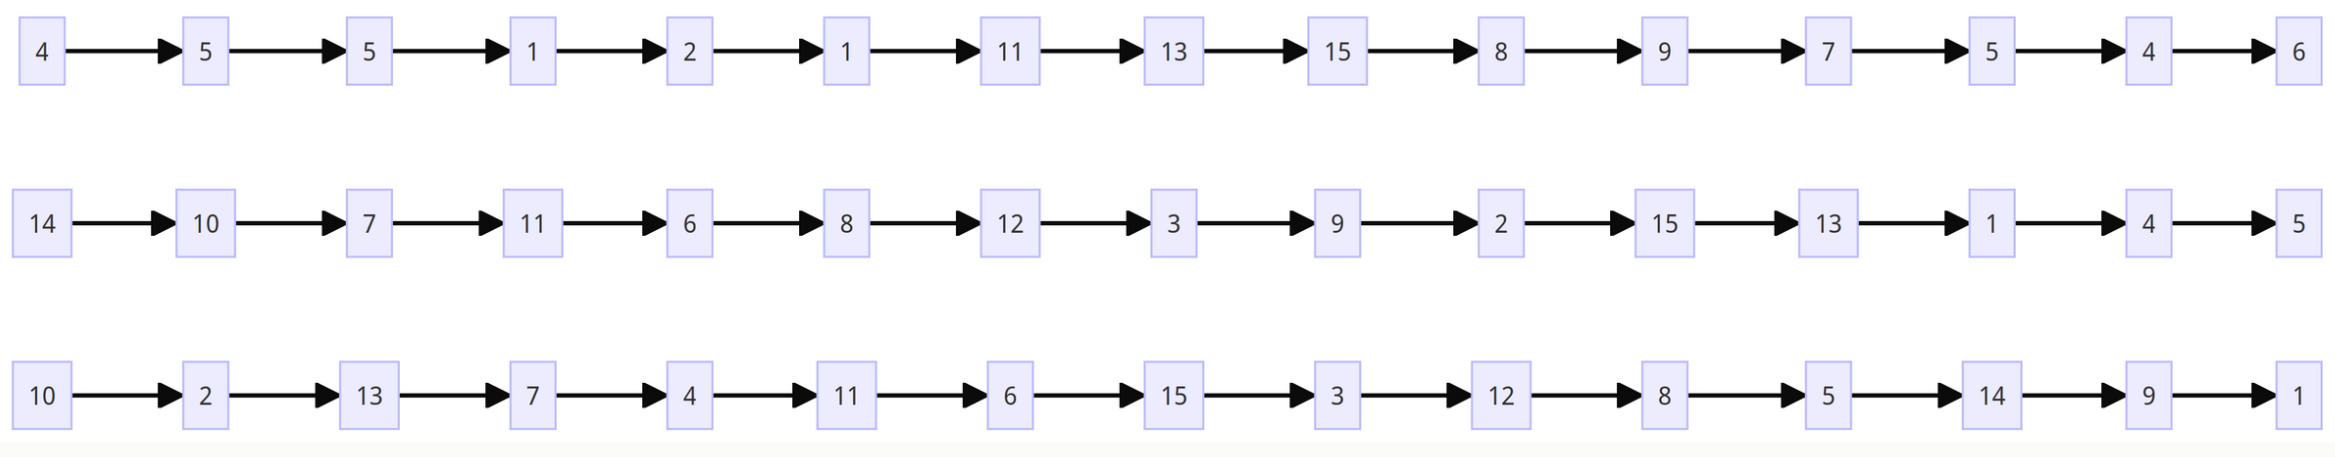

In [5]:
from IPython.display import Image, display
filename = os.path.join(parent_dir, 'figures/bootstrapping_iid.png')

display(Image(filename=filename))

### Key Aspects
1. Model-Free Inference
   - Non-parametric
   - For unknown/complex distributions

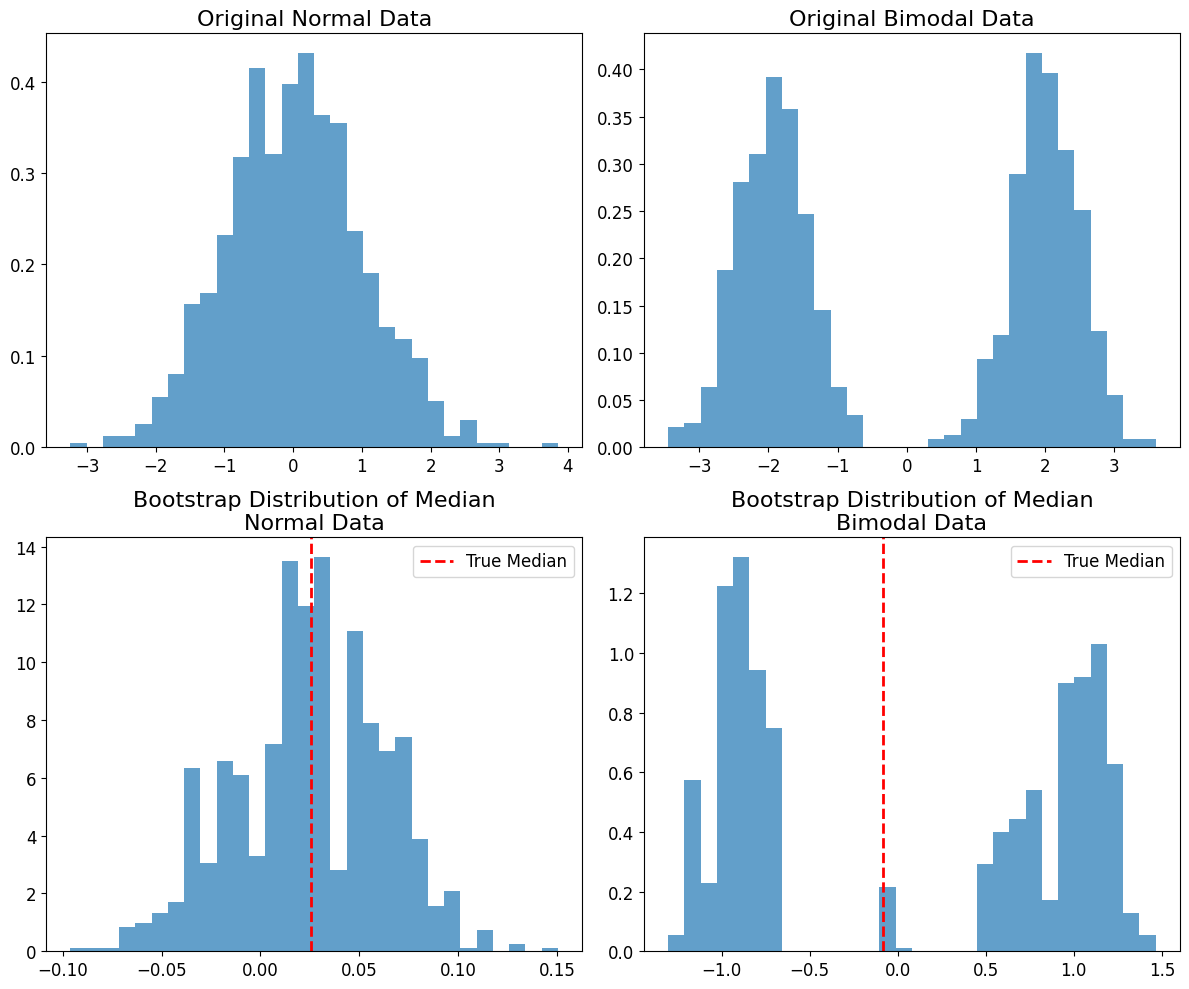

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

# Generate data
normal_data = np.random.normal(0, 1, 1000)
bimodal_data = np.concatenate(
    [np.random.normal(-2, 0.5, 500), np.random.normal(2, 0.5, 500)])


def bootstrap_median(data, n_bootstrap=1000):
    medians = np.zeros(n_bootstrap)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        medians[i] = np.median(sample)
    return medians


# Perform bootstrap
normal_bootstrap = bootstrap_median(normal_data)
bimodal_bootstrap = bootstrap_median(bimodal_data)

# Create plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Normal distribution
ax1.hist(normal_data, bins=30, density=True, alpha=0.7)
ax1.set_title('Original Normal Data')

ax3.hist(normal_bootstrap, bins=30, density=True, alpha=0.7)
ax3.axvline(np.median(normal_data), color='r',
            linestyle='dashed', label='True Median')
ax3.set_title('Bootstrap Distribution of Median\nNormal Data')
ax3.legend()

# Bimodal distribution
ax2.hist(bimodal_data, bins=30, density=True, alpha=0.7)
ax2.set_title('Original Bimodal Data')

ax4.hist(bimodal_bootstrap, bins=30, density=True, alpha=0.7)
ax4.axvline(np.median(bimodal_data), color='r',
            linestyle='dashed', label='True Median')
ax4.set_title('Bootstrap Distribution of Median\nBimodal Data')
ax4.legend()

plt.tight_layout()
plt.show()

- Uncertainty Assessment
  - Estimates confidence intervals, standard errors

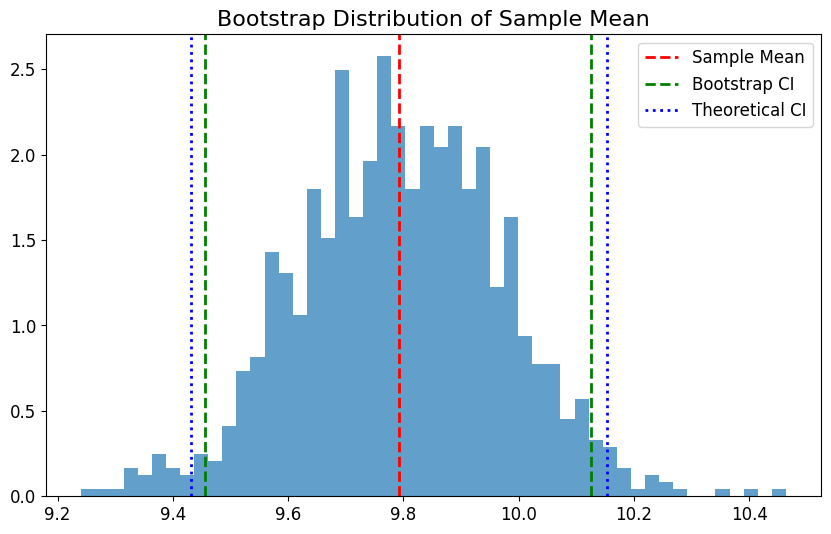

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate sample data
np.random.seed(42)
data = np.random.normal(10, 2, 100)

# Bootstrap
n_bootstrap = 1000
bootstrap_means = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_means[i] = np.mean(bootstrap_sample)

# Calculate confidence intervals
sample_mean = np.mean(data)
bootstrap_ci = np.percentile(bootstrap_means, [2.5, 97.5])
theoretical_ci = stats.t.interval(
    0.95, len(data)-1, loc=sample_mean, scale=stats.sem(data))

# Plot
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means, bins=50, density=True, alpha=0.7)
plt.axvline(sample_mean, color='r', linestyle='dashed',
            linewidth=2, label='Sample Mean')
plt.axvline(bootstrap_ci[0], color='g',
            linestyle='dashed', linewidth=2, label='Bootstrap CI')
plt.axvline(bootstrap_ci[1], color='g', linestyle='dashed', linewidth=2)
plt.axvline(theoretical_ci[0], color='b',
            linestyle='dotted', linewidth=2, label='Theoretical CI')
plt.axvline(theoretical_ci[1], color='b', linestyle='dotted', linewidth=2)
plt.title('Bootstrap Distribution of Sample Mean')
plt.legend()
plt.show()

- Model Validation
  - Assesses model stability, reliability

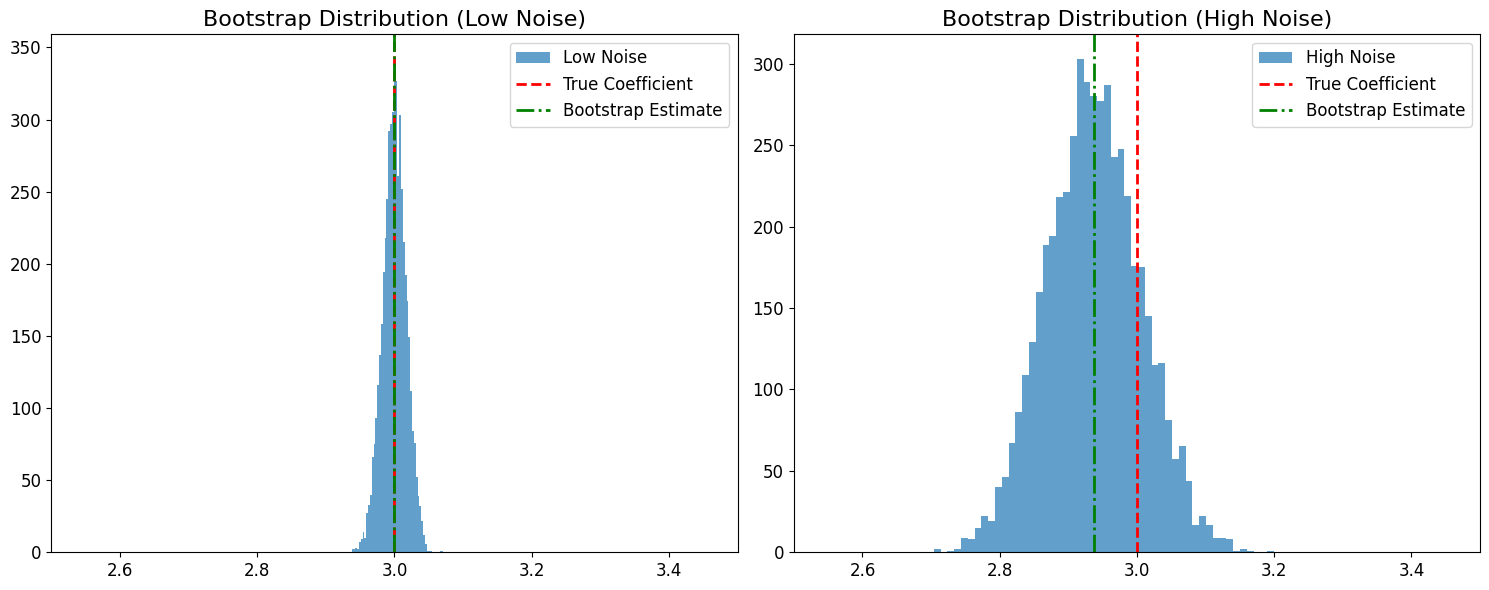

Low Noise - Bootstrap Estimate: 2.9999, True Value: 3.0000
High Noise - Bootstrap Estimate: 2.9369, True Value: 3.0000
Low Noise - Std Dev: 0.0172
High Noise - Std Dev: 0.0688


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def generate_data(n, noise_level):
    X = np.random.rand(n, 1)
    y = 2 + 3 * X + np.random.randn(n, 1) * noise_level
    return X, y


def bootstrap_coef(X, y, n_bootstrap=5000):
    coefs = np.zeros(n_bootstrap)
    for i in range(n_bootstrap):
        indices = np.random.randint(0, len(X), len(X))
        X_boot, y_boot = X[indices], y[indices]
        model = LinearRegression().fit(X_boot, y_boot)
        coefs[i] = model.coef_[0]
    return coefs


# Parameters
np.random.seed(42)  # for reproducibility
n_points = 1000
n_simulations = 10
low_noise = 0.5
high_noise = 2.0

# Run multiple simulations
low_noise_coefs = []
high_noise_coefs = []

for _ in range(n_simulations):
    X_low, y_low = generate_data(n_points, low_noise)
    X_high, y_high = generate_data(n_points, high_noise)

    low_noise_coefs.append(bootstrap_coef(X_low, y_low))
    high_noise_coefs.append(bootstrap_coef(X_high, y_high))

# Average the results
low_noise_avg = np.mean(low_noise_coefs, axis=0)
high_noise_avg = np.mean(high_noise_coefs, axis=0)

# Calculate bootstrap estimates
low_noise_estimate = np.mean(low_noise_avg)
high_noise_estimate = np.mean(high_noise_avg)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(low_noise_avg, bins=50, alpha=0.7, label='Low Noise')
ax1.axvline(3, color='r', linestyle='dashed', label='True Coefficient')
ax1.axvline(low_noise_estimate, color='g',
            linestyle='dashdot', label='Bootstrap Estimate')
ax1.set_title('Bootstrap Distribution (Low Noise)')
ax1.legend()
ax1.set_xlim(2.5, 3.5)

ax2.hist(high_noise_avg, bins=50, alpha=0.7, label='High Noise')
ax2.axvline(3, color='r', linestyle='dashed', label='True Coefficient')
ax2.axvline(high_noise_estimate, color='g',
            linestyle='dashdot', label='Bootstrap Estimate')
ax2.set_title('Bootstrap Distribution (High Noise)')
ax2.legend()
ax2.set_xlim(2.5, 3.5)

plt.tight_layout()
plt.show()

# Print summary statistics
print(
    f"Low Noise - Bootstrap Estimate: {low_noise_estimate:.4f}, True Value: 3.0000")
print(
    f"High Noise - Bootstrap Estimate: {high_noise_estimate:.4f}, True Value: 3.0000")
print(f"Low Noise - Std Dev: {np.std(low_noise_avg):.4f}")
print(f"High Noise - Std Dev: {np.std(high_noise_avg):.4f}")

- Complex Estimators
  - Empirical distribution examination

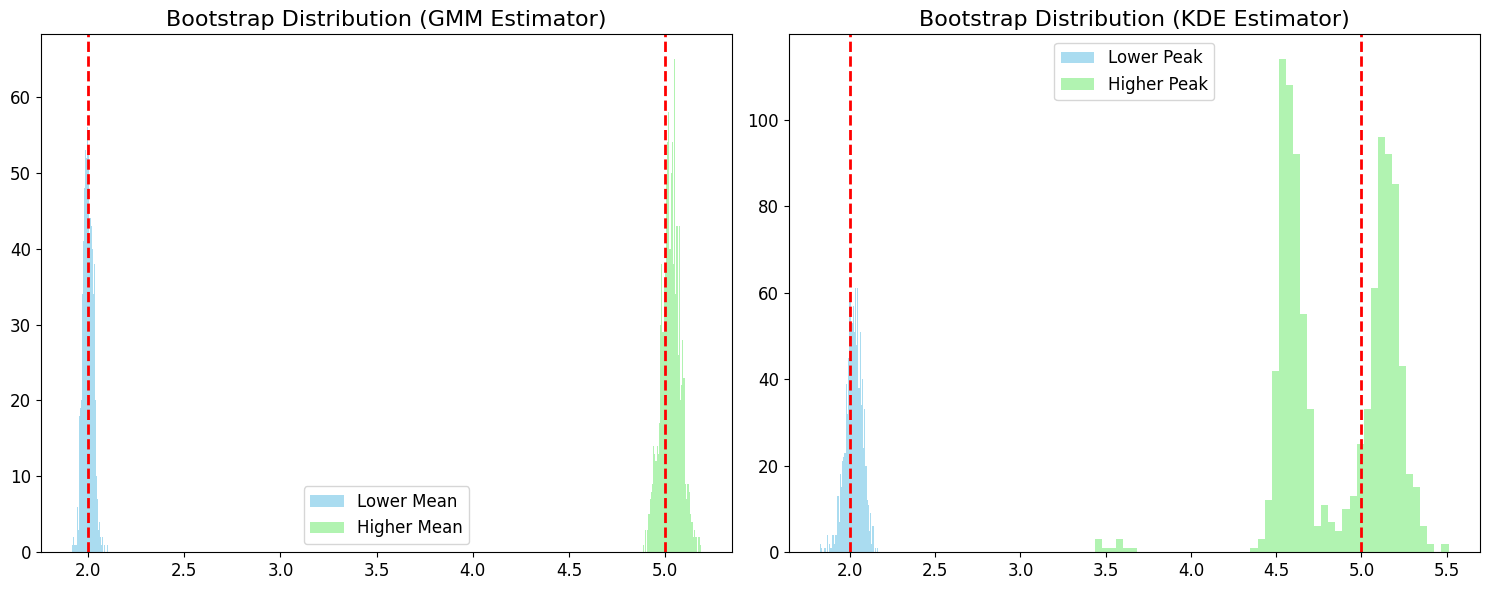

GMM Estimator:
Lower Mean - Bootstrap Median: 1.9988, True Value: 2.0000
Higher Mean - Bootstrap Median: 5.0292, True Value: 5.0000

KDE Estimator:
Lower Peak - Bootstrap Median: 2.0244, True Value: 2.0000
Higher Peak - Bootstrap Median: 4.8938, True Value: 5.0000


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity


def bootstrap_complex_estimators(data, n_bootstrap=1000):
    gmm_estimates = []
    kde_estimates = []
    n = len(data)

    for _ in range(n_bootstrap):
        boot_sample = np.random.choice(data, size=n, replace=True)

        # GMM estimator
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(boot_sample.reshape(-1, 1))
        gmm_estimates.append(np.sort(gmm.means_.flatten())
                             )  # Store both means, sorted

        # KDE estimator
        kde = KernelDensity(kernel='gaussian', bandwidth='scott').fit(
            boot_sample.reshape(-1, 1))
        x_range = np.linspace(
            boot_sample.min(), boot_sample.max(), 1000).reshape(-1, 1)
        kde_density = np.exp(kde.score_samples(x_range))
        peaks = x_range[np.r_[True, kde_density[1:] > kde_density[:-1]] &
                        np.r_[kde_density[:-1] > kde_density[1:], True]].flatten()
        # Store the two most prominent peaks
        kde_estimates.append(np.sort(peaks)[:2])

    return np.array(gmm_estimates), np.array(kde_estimates)


# Generate some complex data
np.random.seed(42)
data = np.concatenate([
    np.random.normal(loc=2, scale=0.5, size=500),
    np.random.normal(loc=5, scale=1, size=500)
])

# Perform bootstrap
gmm_estimates, kde_estimates = bootstrap_complex_estimators(data)

# True values
true_values = [2, 5]  # The two means used in data generation

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(gmm_estimates[:, 0], bins=50, alpha=0.7,
         color='skyblue', label='Lower Mean')
ax1.hist(gmm_estimates[:, 1], bins=50, alpha=0.7,
         color='lightgreen', label='Higher Mean')
for tv in true_values:
    ax1.axvline(tv, color='r', linestyle='dashed')
ax1.set_title('Bootstrap Distribution (GMM Estimator)')
ax1.legend()

ax2.hist(kde_estimates[:, 0], bins=50, alpha=0.7,
         color='skyblue', label='Lower Peak')
ax2.hist(kde_estimates[:, 1], bins=50, alpha=0.7,
         color='lightgreen', label='Higher Peak')
for tv in true_values:
    ax2.axvline(tv, color='r', linestyle='dashed')
ax2.set_title('Bootstrap Distribution (KDE Estimator)')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("GMM Estimator:")
print(f"Lower Mean - Bootstrap Median: {np.median(
    gmm_estimates[:, 0]):.4f}, True Value: {true_values[0]:.4f}")
print(f"Higher Mean - Bootstrap Median: {np.median(
    gmm_estimates[:, 1]):.4f}, True Value: {true_values[1]:.4f}")
print("\nKDE Estimator:")
print(f"Lower Peak - Bootstrap Median: {np.median(
    kde_estimates[:, 0]):.4f}, True Value: {true_values[0]:.4f}")
print(f"Higher Peak - Bootstrap Median: {np.median(
    kde_estimates[:, 1]):.4f}, True Value: {true_values[1]:.4f}")



### Time Series Challenges
- IID bootstrapping unsuitable
- Must respect temporal structure
- Specialized methods needed

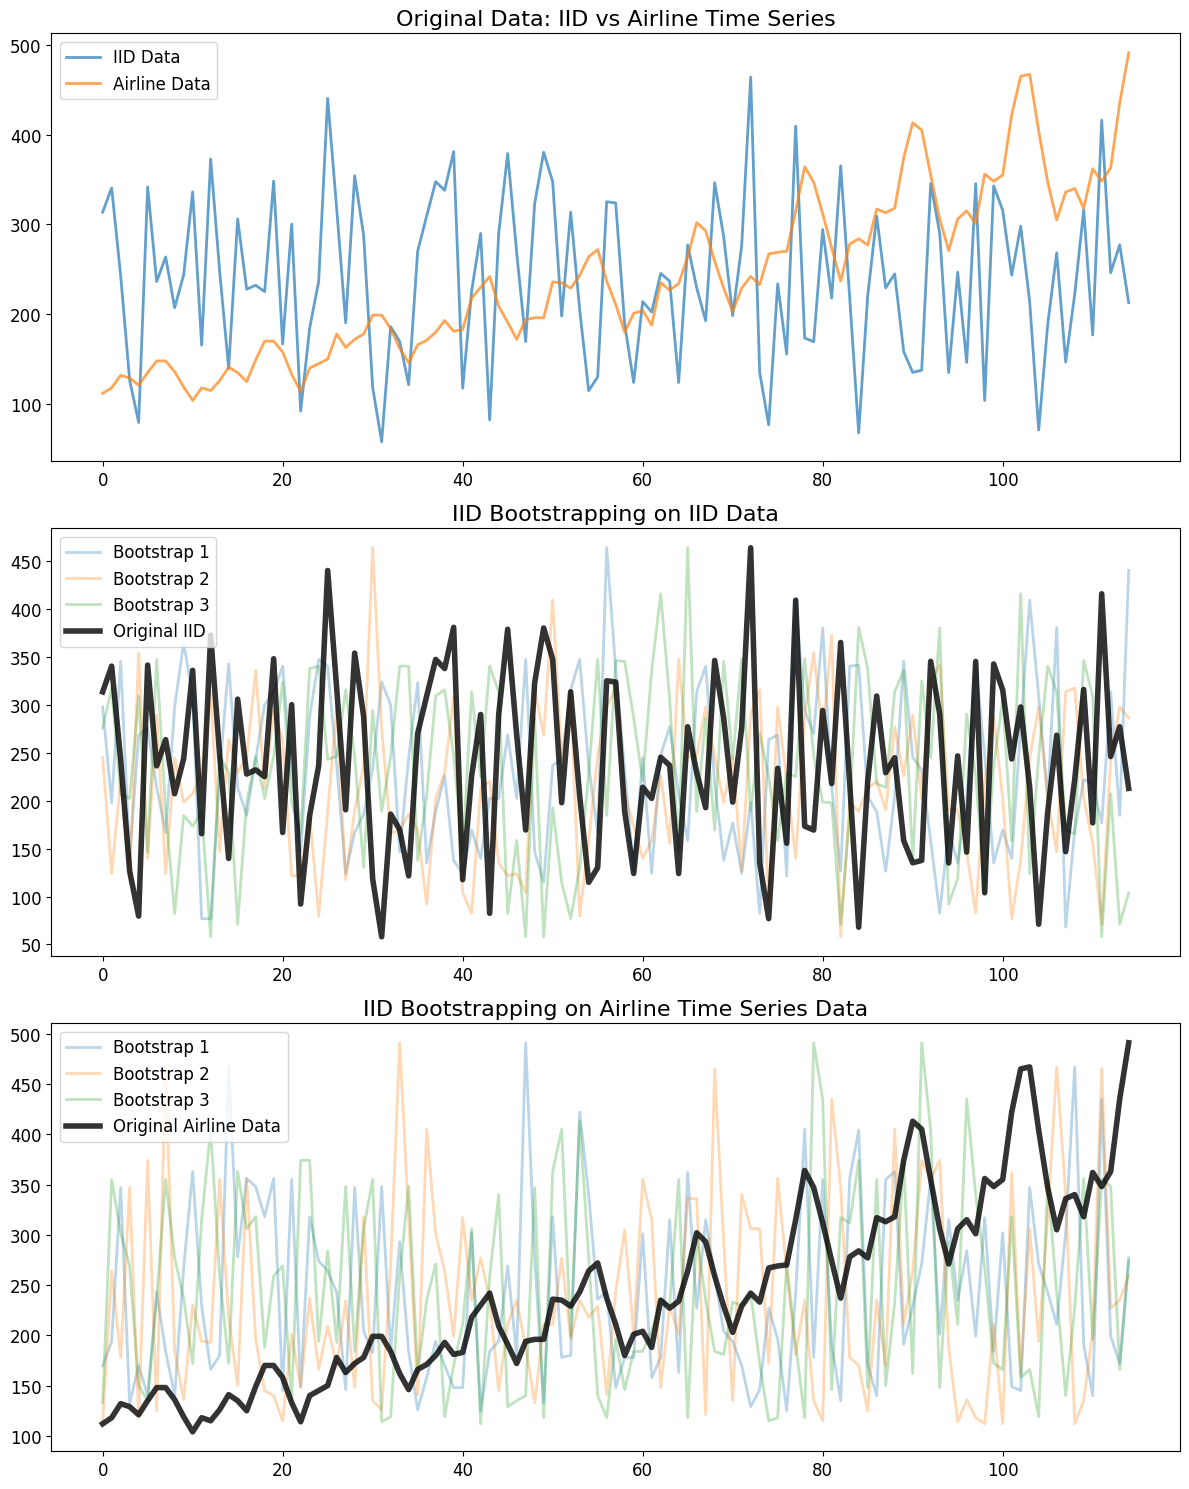

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split


# Load the airline dataset
y = load_airline()

# Split the data into train and test sets
y_train, y_test = temporal_train_test_split(y, test_size=0.2)

# Convert to numpy array for easier manipulation
ts_data = y_train.values

# Generate IID data with similar properties to the airline data
iid_data = np.random.normal(ts_data.mean(), ts_data.std(), len(ts_data))

# Set random seed for reproducibility
np.random.seed(42)

# Create the plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot 1: Original Data
ax1.plot(iid_data, label='IID Data', alpha=0.7)
ax1.plot(ts_data, label='Airline Data', alpha=0.7)
ax1.set_title('Original Data: IID vs Airline Time Series')
ax1.legend()

# Plot 2: IID Bootstrapping on IID Data
for i in range(3):
    bootstrap_iid = np.random.choice(
        iid_data, size=len(iid_data), replace=True)
    ax2.plot(bootstrap_iid, label=f'Bootstrap {i+1}', alpha=0.3)
ax2.plot(iid_data, label='Original IID', color='black', linewidth=4, alpha=0.8)
ax2.set_title('IID Bootstrapping on IID Data')
ax2.legend()

# Plot 3: IID Bootstrapping on Time Series Data
for i in range(3):
    bootstrap_ts = np.random.choice(ts_data, size=len(ts_data), replace=True)
    ax3.plot(bootstrap_ts, label=f'Bootstrap {i+1}', alpha=0.3)
ax3.plot(ts_data, label='Original Airline Data',
         color='black', linewidth=4, alpha=0.8)
ax3.set_title('IID Bootstrapping on Airline Time Series Data')
ax3.legend()

plt.tight_layout()
plt.show()


## 2. `tsbootstrap`: Your Toolkit for Time Series Resampling

### Project Goals:
- Unified, sklearn-like interface
- Flexible block length handling
- Support univariate/multivariate series
- Integrate with libraries like sktime

### Key Features:

1. **Block Bootstrap Methods:**
   - Moving
   - Circular
   - Stationary
   - Non-Overlapping

2. **Window-based Methods:**
   - Bartlett
   - Blackman
   - Hamming
   - Hanning
   - Tukey

3. **Model-based Methods:**
   - Residual
   - Distribution
   - Markov
   - Sieve

4. **Statistic-Preserving Bootstrap**

5. **Customizable:**
   - Block length sampling
   - Block generation



```mermaid
%%{init: {
  "theme": "default",
  "themeVariables": {
    "primaryColor": "#3498db",
    "primaryTextColor": "#ffffff",
    "primaryBorderColor": "#2980b9",
    "lineColor": "#34495e",
    "secondaryColor": "#2ecc71",
    "tertiaryColor": "#e74c3c",
    "tertiaryTextColor": "#ffffff",
    "tertiaryBorderColor": "#c0392b",
    "fontFamily": "Arial, sans-serif",
    "fontSize": "18px",
    "noteBkgColor": "#f5f5f5",
    "noteTextColor": "#333",
    "noteBorderColor": "#ddd",
    "edgeLabelBackground": "#ffffff"
  },
  "flowchart": {
    "nodeSpacing": 10,
    "rankSpacing": 30,
    "curve": "basis",
    "lineWidth": 2,
    "arrowMarkerAbsolute": true
  }
}}%%

graph LR
    %% Define styles
    classDef green fill:#90EE90,stroke:#333,stroke-width:2px;
    classDef orange fill:#FFA500,stroke:#333,stroke-width:2px;
    classDef blue fill:#87CEFA,stroke:#333,stroke-width:2px;
    classDef gray fill:#D3D3D3,stroke:#333,stroke-width:2px;

    %% Legend
    subgraph Legend
        L1[Base Class]:::green
        L2[Intermediate Class]:::orange
        L3[Specific Method]:::blue
        L4[Utility Class]:::gray
    end

    %% The rest of the diagram content remains the same as in the previous version

    %% Top row
    BaseStatisticPreserving[BaseStatisticPreserving]:::orange
    TimeSeriesModel[TimeSeriesModel]:::gray

    %% Second row
    WholeStatisticPreserving[WholeStatisticPreserving]:::blue
    BlockStatisticPreserving[BlockStatisticPreserving]:::blue
    TSFit[TSFit]:::gray
    RankLags[RankLags]:::gray

    %% Third row
    TSFitBestLag[TSFitBestLag]:::gray
    BaseTimeSeries[BaseTimeSeries]:::green

    %% Fourth row
    BaseResidual[BaseResidual]:::orange
    BaseStatisticPreserving2[BaseStatisticPreserving]:::orange
    Block[Block]:::orange
    BlockGenerator[BlockGenerator]:::gray
    BlockLengthSampler[BlockLengthSampler]:::gray
    BlockResampler[BlockResampler]:::gray

    %% Fifth row
    BaseDistribution[BaseDistribution]:::blue
    WholeResidual[WholeResidual]:::blue
    BaseMarkov[BaseMarkov]:::blue
    BlockResidual[BlockResidual]:::blue
    BlockCompressor[BlockCompressor]:::gray
    MarkovTransitionMatrixCalculator[MarkovTransitionMatrixCalculator]:::gray
    BaseSieve[BaseSieve]:::blue
    CircularBlock[CircularBlock]:::blue
    MovingBlock[MovingBlock]:::blue
    BaseBlock[BaseBlock]:::blue
    Stationary[Stationary]:::blue
    NonOverlappingBlock[NonOverlappingBlock]:::blue

    %% Sixth row
    WholeDistribution[WholeDistribution]:::blue
    BlockDistribution[BlockDistribution]:::blue
    WholeMarkov[WholeMarkov]:::blue
    BlockMarkov[BlockMarkov]:::blue
    MarkovSampler[MarkovSampler]:::gray
    WholeSieve[WholeSieve]:::blue
    BlockSieve[BlockSieve]:::blue
    Blackman[Blackman]:::blue
    Hamming[Hamming]:::blue
    Hanning[Hanning]:::blue
    Tukey[Tukey]:::blue
    Bartletts[Bartletts]:::blue

    %% Connections
    BaseStatisticPreserving --> WholeStatisticPreserving
    BaseStatisticPreserving --> BlockStatisticPreserving
    TimeSeriesModel --> TSFit
    TSFit --> TSFitBestLag
    RankLags -.-> TSFitBestLag
    TSFitBestLag -.-> BaseResidual
    BaseTimeSeries --> BaseResidual
    BaseTimeSeries --> BaseStatisticPreserving2
    BaseTimeSeries --> Block
    BaseResidual --> BaseDistribution
    BaseResidual --> WholeResidual
    BaseResidual --> BaseMarkov
    BaseResidual --> BlockResidual
    BaseResidual --> BaseSieve
    BlockGenerator -.-> Block
    BlockLengthSampler -.-> Block
    BlockResampler -.-> Block
    BaseDistribution --> WholeDistribution
    BaseDistribution --> BlockDistribution
    BaseMarkov --> WholeMarko%%{init: {
  "theme": "default",
  "themeVariables": {
    "primaryColor": "#3498db",
    "primaryTextColor": "#ffffff",
    "primaryBorderColor": "#2980b9",
    "lineColor": "#34495e",
    "secondaryColor": "#2ecc71",
    "tertiaryColor": "#e74c3c",
    "tertiaryTextColor": "#ffffff",
    "tertiaryBorderColor": "#c0392b",
    "fontFamily": "Arial, sans-serif",
    "fontSize": "18px",
    "noteBkgColor": "#f5f5f5",
    "noteTextColor": "#333",
    "noteBorderColor": "#ddd",
    "edgeLabelBackground": "#ffffff"
  },
  "flowchart": {
    "nodeSpacing": 10,
    "rankSpacing": 30,
    "curve": "basis",
    "lineWidth": 2,
    "arrowMarkerAbsolute": true
  }
}}%%v
    BaseMarkov --> BlockMarkov
    BlockCompressor -.-> MarkovSampler
    MarkovTransitionMatrixCalculator -.-> MarkovSampler
    MarkovSampler -.-> WholeMarkov
    MarkovSampler -.-> BlockMarkov
    BaseSieve --> WholeSieve
    BaseSieve --> BlockSieve
    Block --> CircularBlock
    Block --> MovingBlock
    Block --> BaseBlock
    Block --> Stationary
    Block --> NonOverlappingBlock
    BaseBlock --> Blackman
    BaseBlock --> Hamming
    BaseBlock --> Hanning
    BaseBlock --> Tukey
    BaseBlock --> Bartletts
```

| Bootstrapping Method | Class (...`Bootstrap`) | Salient Features |
|----------------------|------------------------|-------------------|
| Moving Block | `MovingBlock` | Suitable for series with significant intra-block dependencies; avoid for weak dependencies |
| Circular Block | `CircularBlock` | Ideal for seasonal/cyclical data; not recommended for non-cyclical data |
| Stationary | `StationaryBlock` | Best for data with varying dependency lengths; less effective for uniform dependency lengths |
| Non-Overlapping Block | `NonOverlappingBlock` | Effective for data with distinct segments; not suitable for continuous or highly dependent data |
| Tapered Block | `Bartletts`, `Hamming`, `Blackman`, `Tukey` | Mitigates edge effects using window functions; requires matching window functions to data characteristics |
| Residual | `WholeResidual`, `BlockResidual` | Evaluates model-based uncertainty; not intended for non-model analyses |
| Statistic-Preserving | `WholeStatisticPreserving`, `BlockStatisticPreserving` | Maintains key statistical properties; not for general purposes without specific preservation needs |
| Distribution | `WholeDistribution`, `BlockDistribution` | Leverages known distributions; inappropriate for unknown distributions |
| Markov | `WholeMarkov`, `BlockMarkov` | Suitable for Markovian time series; avoid for non-Markovian series |
| Sieve | `WholeSieve`, `BlockSieve` | Designed for autoregressive models; not recommended for non-autoregressive series |

Table: Overview of bootstrapping classes in `tsbootstrap`.

In [13]:
import pandas as pd

# load data
data = pd.read_pickle(file_path)

print(data)


                         value
series_name date              
T1          1976-06-01  8000.0
            1976-07-01  8350.0
            1976-08-01  8570.0
            1976-09-01  7700.0
            1976-10-01  7080.0
...                        ...
T48000      2015-12-31  5020.0
            2016-01-31  4950.0
            2016-02-29  4860.0
            2016-03-31  5140.0
            2016-04-30  5100.0

[11246411 rows x 1 columns]


In [14]:
# Select a single series
series_name = 'T1'
single_series = data.loc[series_name]['value']

# Ensure the index is a DatetimeIndex with monthly frequency
single_series.index = pd.date_range(
    start=single_series.index[0], periods=len(single_series), freq='MS')

# Split into train and test sets
train_size = int(len(single_series) * 0.8)
train, test = single_series[:train_size], single_series[train_size:]

print(f"Train set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Train set shape: (389,)
Test set shape: (98,)


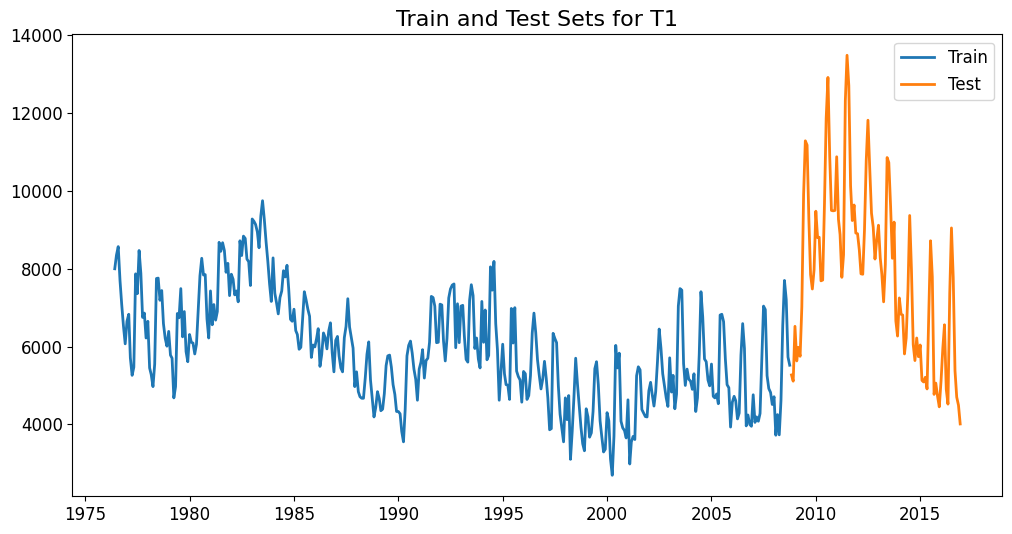

In [15]:
# plot the train and test sets
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title(f'Train and Test Sets for {series_name}')
plt.legend()
plt.show()

In [16]:
from IPython.display import display, HTML

# Define image data
image_data = [
    {'path': os.path.join(
        parent_dir, 'figures/bootstrapping_mbb.png'), 'label': 'Moving BB'},
    {'path': os.path.join(
        parent_dir, 'figures/bootstrapping_cbb.png'), 'label': 'Circular BB'},
    {'path': os.path.join(
        parent_dir, 'figures/bootstrapping_sbb.png'), 'label': 'Stationary BB'},
    {'path': os.path.join(
        parent_dir, 'figures/bootstrapping_nobb.png'), 'label': 'Non-Overlapping BB'}
]

# Create the HTML for the 2x2 grid
html = '''
<style>
    .image-grid {
        display: grid;
        grid-template-columns: 1fr 1fr;
        grid-gap: 10px;
        width: 100%;
    }
    .image-cell {
        text-align: center;
    }
    .image-cell img {
        width: 100%;
        height: auto;
    }
    .image-label {
        margin-top: 5px;
        font-weight: bold;
    }
</style>
<div class="image-grid">
'''

for image in image_data:
    html += f'''
    <div class="image-cell">
        <img src="{image['path']}">
        <div class="image-label">{image['label']}</div>
    </div>
    '''

html += '</div>'

# Display the grid
display(HTML(html))

```mermaid
%%{init: {
  "theme": "default",
  "themeVariables": {
    "primaryColor": "#3498db",
    "primaryTextColor": "#ffffff",
    "primaryBorderColor": "#2980b9",
    "lineColor": "#34495e",
    "secondaryColor": "#2ecc71",
    "tertiaryColor": "#e74c3c",
    "tertiaryTextColor": "#ffffff",
    "tertiaryBorderColor": "#c0392b",
    "fontFamily": "Arial, sans-serif",
    "fontSize": "18px",
    "noteBkgColor": "#f5f5f5",
    "noteTextColor": "#333",
    "noteBorderColor": "#ddd",
    "edgeLabelBackground": "#ffffff"
  },
  "flowchart": {
    "nodeSpacing": 10,
    "rankSpacing": 30,
    "curve": "basis",
    "lineWidth": 2,
    "arrowMarkerAbsolute": true
  }
}}%%
%%{init: {
  "theme": "default",
  "themeVariables": {
    "primaryColor": "#3498db",
    "primaryTextColor": "#ffffff",
    "primaryBorderColor": "#2980b9",
    "lineColor": "#34495e",
    "secondaryColor": "#2ecc71",
    "tertiaryColor": "#e74c3c",
    "tertiaryTextColor": "#ffffff",
    "tertiaryBorderColor": "#c0392b",
    "fontFamily": "Arial, sans-serif",
    "fontSize": "18px",
    "noteBkgColor": "#f5f5f5",
    "noteTextColor": "#333",
    "noteBorderColor": "#ddd",
    "edgeLabelBackground": "#ffffff"
  },
  "flowchart": {
    "nodeSpacing": 10,
    "rankSpacing": 30,
    "curve": "basis",
    "lineWidth": 2,
    "arrowMarkerAbsolute": true
  }
}}%%
graph LR
    A[BlockLengthSampler<br>Determines block lengths] -->|Provides block length| B[BlockGenerator<br>Generates blocks of indices]
    B -->|Generates block indices| C[BlockResampler<br>Performs resampling]
    
    subgraph BlockLengthSampler
        A1[sample_block_length<br>Samples a block length]
    end
    
    subgraph BlockGenerator
        B1[generate_non_overlapping_blocks<br>Creates non-overlapping blocks]
        B2[generate_overlapping_blocks<br>Creates overlapping blocks]
        B3[generate_blocks<br>General block generation method]
    end
    
    subgraph BlockResampler
        C1[resample<br>Main resampling method]
        C2[_resample_1d<br>Resamples 1D data]
        C3[_resample_2d<br>Resamples 2D data]
    end
    
    style A fill:#f9d5e5,stroke:#333,stroke-width:2px
    style B fill:#eeeeee,stroke:#333,stroke-width:2px
    style C fill:#dcf3ff,stroke:#333,stroke-width:2px

### 🔍 Block Length Sampling in tsbootstrap

🔹 Importance:
  • Crucial in block bootstrapping methods
  • Determines preservation of original structure and dependencies

🔸 Features in tsbootstrap:
  • Various strategies for block length sampling
  • Flexibility for users to choose appropriate method

🔹 Impact:
  • Affects how much original data structure is maintained
  • Influences the quality of bootstrap results

🔸 User benefit:
  • Can select method best suited for specific data characteristics
  • Allows for customization of bootstrapping process

🔹 Available options:
  • Multiple sampling strategies to choose from
  • Adaptable to different types of time series data


Parameters:
`avg_block_length` : float
    The average length of blocks to be sampled.

`block_length_distribution` : str, optional
    The distribution to use for sampling block lengths. Options include "geometric", "poisson", and "fixed". Default is "geometric".

`rng` : Generator, optional
    The random number generator. If None, numpy's default RNG is used.

Key Method:
`sample_block_length()`
    Samples a block length based on the specified distribution.

Output:
    Returns an integer representing the sampled block length.

In [ ]:
# Example of block length sampling
from tsbootstrap.block_length_sampler import BlockLengthSampler

block_length_sampler = BlockLengthSampler()


In [ ]:
for _ in range(5):
    sampled_block_length = block_length_sampler.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2


Next we try the Normal distribution

In [ ]:
block_length_sampler_normal = BlockLengthSampler(block_length_distribution="normal")

In [ ]:
for _ in range(5):
    sampled_block_length = block_length_sampler_normal.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 1
Sampled block lengths: 3
Sampled block lengths: 3
Sampled block lengths: 3
Sampled block lengths: 2


What happens if we start over?

In [ ]:
block_length_sampler_normal = BlockLengthSampler(
    block_length_distribution="normal")
for _ in range(5):
    sampled_block_length = block_length_sampler_normal.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2
Sampled block lengths: 2


We get different results. Let's try and fix the random number.

In [ ]:
block_length_sampler_normal = BlockLengthSampler(
    block_length_distribution="normal", rng=42)
for _ in range(5):
    sampled_block_length = block_length_sampler_normal.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 2
Sampled block lengths: 1
Sampled block lengths: 3
Sampled block lengths: 3
Sampled block lengths: 1


In [ ]:
block_length_sampler_normal = BlockLengthSampler(
    block_length_distribution="normal", rng=42)
for _ in range(5):
    sampled_block_length = block_length_sampler_normal.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 2
Sampled block lengths: 1
Sampled block lengths: 3
Sampled block lengths: 3
Sampled block lengths: 1


Et voila! Same sequence of repeatable results.

Let's try the Poisson distribution with `avg_block_length` of 4

In [ ]:
block_length_sampler_poisson = BlockLengthSampler(avg_block_length=4, block_length_distribution="poisson", rng=42)
for _ in range(5):
    sampled_block_length = block_length_sampler_poisson.sample_block_length()
    print("Sampled block lengths:", sampled_block_length)

Sampled block lengths: 6
Sampled block lengths: 3
Sampled block lengths: 6
Sampled block lengths: 8
Sampled block lengths: 1


### 📦 Block Generator in tsbootstrap

🔹 Purpose:
    Generates blocks of indices for bootstrapping
    Core component in block-based resampling

🔸 Key features:
    Utilizes BlockLengthSampler for block size determination
    Supports both overlapping and non-overlapping blocks

🔹 Parameters:
    `block_length_sampler`: Determines block lengths
    `input_length`: Length of original time series
    `wrap_around_flag`: Allows circular sampling
    `rng`: Random number generator
    `overlap_length`: For overlapping blocks
    `min_block_length`: Minimum block size for overlapping blocks

🔸 Main method:
    `generate_blocks()`: Creates block indices

🔹 Flexibility:
    Adaptable to various bootstrapping strategies
    Customizable for different time series characteristics

🔸 Output:
    Array of block indices for resampling

In [ ]:
from tsbootstrap.block_generator import BlockGenerator

block_generator = BlockGenerator(
    block_length_sampler=block_length_sampler, input_length=10)

In [ ]:
from pprint import pprint
blocks = block_generator.generate_blocks(overlap_flag=True)
pprint(blocks)
# block_length was 2, hence overlap_length is set to 1 by default

[array([0, 1]),
 array([1, 2]),
 array([2, 3]),
 array([3, 4]),
 array([4, 5]),
 array([5, 6]),
 array([6, 7]),
 array([7, 8]),
 array([8, 9]),
 array([9])]


In [ ]:
block_generator.generate_blocks(overlap_flag=False)

[array([0, 1]), array([2, 3]), array([4, 5]), array([6, 7]), array([8, 9])]

### 📊 BlockResampler in tsbootstrap

🔹 Purpose:
    Performs block resampling on time series data
    Core component in block bootstrap process

🔸 Parameters:
    - `blocks`: List[np.ndarray]
        A list of numpy arrays where each array represents the indices of a block in the time series.
    - `X`: np.ndarray
        The input data array.
    - `block_weights`: Optional[Union[Callable, np.ndarray]]
        An array of weights or a callable function to generate weights. If None, default uniform weights are used.
    - `tapered_weights`: Optional[Union[Callable, np.ndarray]]
        An array of weights to apply to the data within the blocks. If None, default uniform weights are used.
    - `rng`: RngTypes
        Generator for reproducibility. If None, the global random state is used.

🔹 Main Methods:
    - `resample_blocks()`: Resamples blocks and tapered weights
    - `resample_block_indices_and_data()`: Generates block indices and corresponding data

🔸 Key Features:
    - Supports both uniform and custom block weights
    - Implements tapered weights for data within blocks
    - Handles 1D and 2D input arrays
    - Provides flexible weight generation (callable functions or arrays)

🔹 Input Validation:
    - Ensures proper data types and shapes for inputs
    - Validates and normalizes weights

🔸 Resampling Process:
    1. Generates block weights
    2. Resamples blocks with replacement
    3. Applies tapered weights to data within blocks

🔹 Output:
    - Resampled block indices
    - Corresponding resampled and weighted data blocks

In [ ]:
from tsbootstrap import BlockResampler

block_resampler = BlockResampler(blocks = blocks, X = np.arange(10))

In [ ]:
# Resample the blocks
resampled_blocks = block_resampler.resample_blocks()

In [ ]:
from pprint import pprint
pprint(resampled_blocks)

([array([4, 5]), array([3, 4]), array([7, 8]), array([3, 4]), array([5, 6])],
 [array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1])])


## 3. Hands-on with tsbootstrap

In [17]:
from tsbootstrap import MovingBlockBootstrap, CircularBlockBootstrap, StationaryBlockBootstrap, NonOverlappingBlockBootstrap
import numpy as np
from skbase.utils.stdout_mute import StdoutMute

np.random.seed(42)
n_bootstraps = 100
block_length = 12

# Initialize block bootstrap methods
mbb = MovingBlockBootstrap(n_bootstraps=n_bootstraps,
                           block_length=block_length)
cbb = CircularBlockBootstrap(
    n_bootstraps=n_bootstraps, block_length=block_length)
sbb = StationaryBlockBootstrap(
    n_bootstraps=n_bootstraps, block_length=block_length)
nobb = NonOverlappingBlockBootstrap(
    n_bootstraps=n_bootstraps, block_length=block_length)

# Function to count and get shape of generator items
def get_generator_info(generator):
    with StdoutMute():
        samples = list(generator)
    count = len(samples)
    if count > 0:
        shape = (count,) + np.shape(samples[0])
    else:
        shape = (0,)
    return count, shape

# Generate bootstrap samples and get info
methods = [('MBB', mbb), ('CBB', cbb), ('SBB', sbb), ('NOBB', nobb)]
for name, method in methods:
    samples = method.bootstrap(train.values)
    count, shape = get_generator_info(samples)
    print(f"{name} samples count: {count}")
    print(f"{name} samples shape: {shape}")

MBB samples count: 100
MBB samples shape: (100, 389, 1)
CBB samples count: 100
CBB samples shape: (100, 389, 1)
SBB samples count: 100
SBB samples shape: (100, 389, 1)
NOBB samples count: 100
NOBB samples shape: (100, 389, 1)


In [18]:
# Recreate the generator for MBB, CBB, SBB, and NOBB methods
mbb_samples = mbb.bootstrap(train.values)
cbb_samples = cbb.bootstrap(train.values)
sbb_samples = sbb.bootstrap(train.values)
nobb_samples = nobb.bootstrap(train.values)

In [19]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster

import pandas as pd
import numpy as np

def generate_forecast_with_ci(train_series, test_series, bootstrap_samples):
    train_series.index = pd.PeriodIndex(train_series.index, freq='M')
    test_series.index = pd.PeriodIndex(test_series.index, freq='M')

    forecaster = ExponentialSmoothing(seasonal="multiplicative", trend="additive", sp=120,
                                      initialization_method="estimated",
                                      use_boxcox=True, remove_bias=True)
    forecaster = ThetaForecaster(sp=120)

    # Fit on the entire training data
    forecaster.fit(train_series)

    # Generate point forecast for the entire test period
    fh = ForecastingHorizon(test_series.index, is_relative=False)
    point_forecast = forecaster.predict(fh)

    # Generate bootstrap forecasts
    bootstrap_forecasts = []
    with StdoutMute():
        for sample in bootstrap_samples:
            # Ensure the sample is 1-dimensional
            sample = sample.ravel()
            sample_train = pd.Series(
                sample[:len(train_series)], index=train_series.index)
            sample_forecast = forecaster.fit(sample_train).predict(fh)
            bootstrap_forecasts.append(sample_forecast)

    bootstrap_forecasts = np.array([bf.values for bf in bootstrap_forecasts])

    lower_ci = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    upper_ci = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    return point_forecast.values, lower_ci, upper_ci

In [20]:
# Function to print forecast summary
def print_forecast_summary(name, forecast, lower, upper):
    print(f"\n{name} Forecast Summary:")
    if lower is None or upper is None:
        print("Unable to generate confidence intervals.")
        return
    print(f"First forecast point: {
          forecast[0]:.2f} [{lower[0]:.2f}, {upper[0]:.2f}]")
    print(f"Last forecast point: {
          forecast[-1]:.2f} [{lower[-1]:.2f}, {upper[-1]:.2f}]")

In [21]:
import matplotlib.pyplot as plt

def plot_forecast_with_ci(train, test, forecast, lower_ci, upper_ci, method_name):
    plt.figure(figsize=(12, 6))

    # Convert PeriodIndex to DatetimeIndex for plotting
    train_datetime = train.index.to_timestamp()
    test_datetime = test.index.to_timestamp()

    plt.plot(train_datetime, train, label='Training Data', color='blue')
    plt.plot(test_datetime, test, label='Test Data', color='green')

    forecast_index = test_datetime[:len(forecast)]
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_index, lower_ci, upper_ci,
                     color='pink', alpha=0.3, label='95% CI')

    plt.title(f'{method_name} Forecast with Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/home/sgilda/Documents/scipy-2024-private/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



MBB Forecast Summary:
First forecast point: 4858.22 [4490.07, 8182.49]
Last forecast point: 6001.19 [3615.17, 8995.38]


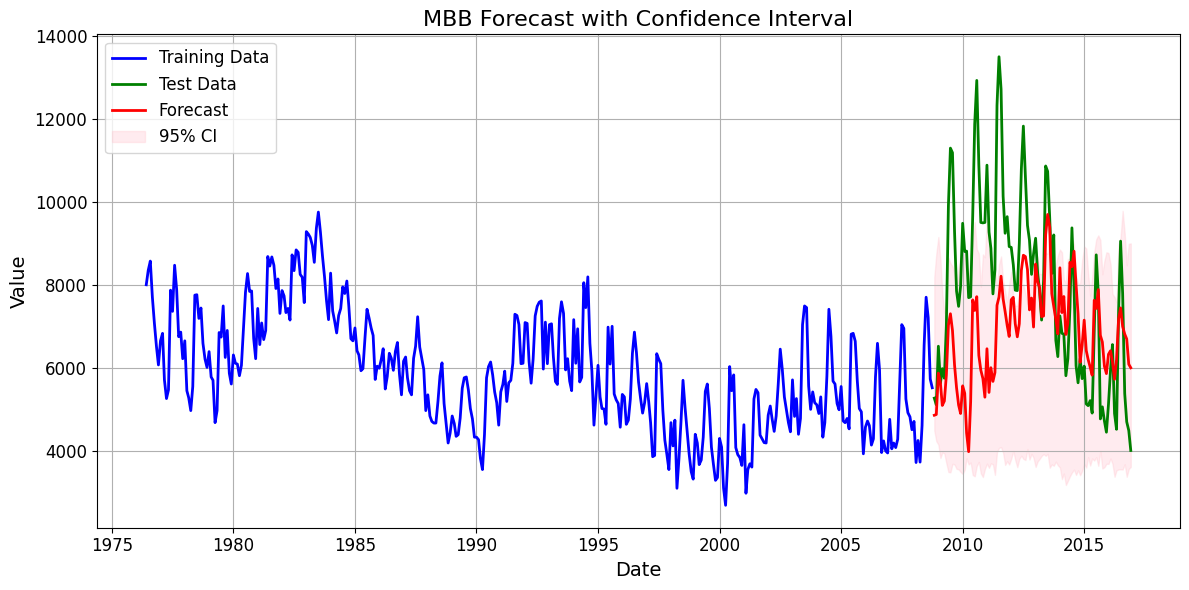


CBB Forecast Summary:
First forecast point: 4858.22 [3640.35, 9186.21]
Last forecast point: 6001.19 [3505.76, 12407.06]


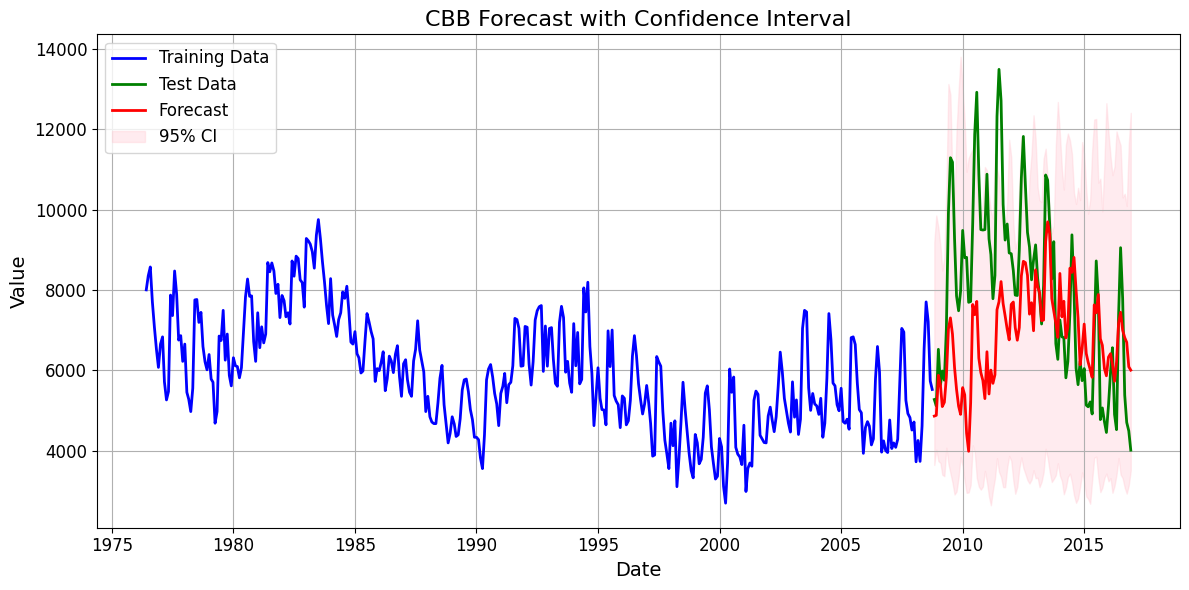


SBB Forecast Summary:
First forecast point: 4858.22 [4195.99, 8089.05]
Last forecast point: 6001.19 [3590.36, 10494.64]


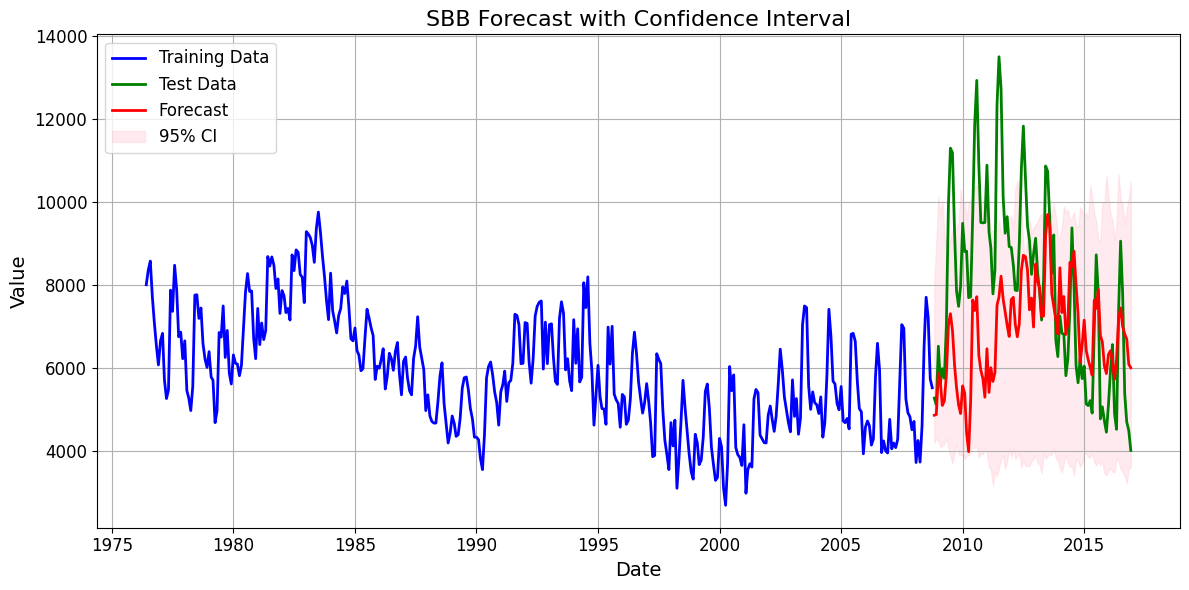

/home/sgilda/Documents/scipy-2024-private/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/sgilda/Documents/scipy-2024-private/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/sgilda/Documents/scipy-2024-private/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



NOBB Forecast Summary:
First forecast point: 4858.22 [4195.73, 10686.18]
Last forecast point: 6001.19 [3380.56, 10874.18]


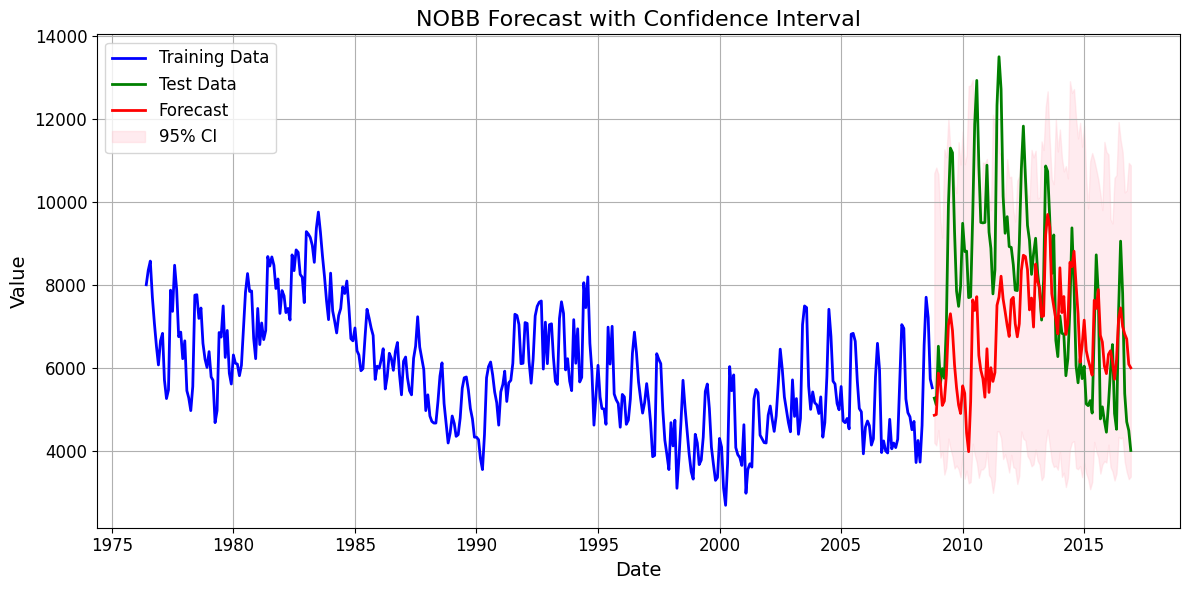

In [22]:
# Generate forecasts and plot results for each method
#horizon = len(test)
for name, method in methods:
    #initial_window = len(train)  # Start with the full training set
    samples = method.bootstrap(train.values)
    forecast, lower, upper = generate_forecast_with_ci(
        train, test, samples)
    # forecast, lower, upper = generate_forecast_with_ci(train, samples, horizon)
    print_forecast_summary(name, forecast, lower, upper)
    plot_forecast_with_ci(train, test, forecast, lower, upper, name)

# Tapered Window Bootstrap Methods

First, let's visualize the window shapes:


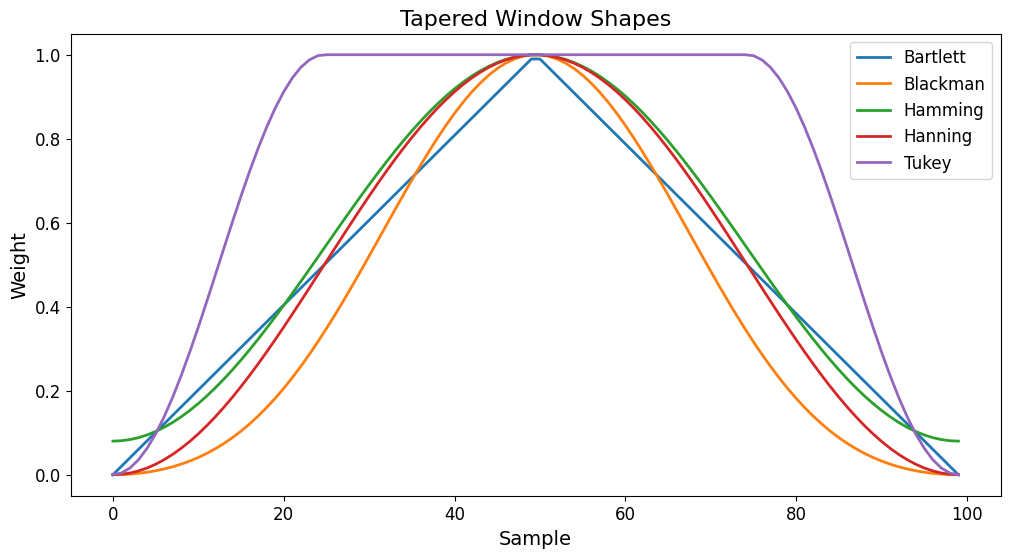

In [23]:
from scipy import signal
import matplotlib.pyplot as plt


def plot_windows(n=100):
    windows = {
        'Bartlett': signal.windows.bartlett(n),
        'Blackman': signal.windows.blackman(n),
        'Hamming': signal.windows.hamming(n),
        'Hanning': signal.windows.hann(n),
        'Tukey': signal.windows.tukey(n)
    }

    fig, ax = plt.subplots(figsize=(12, 6))
    for name, window in windows.items():
        ax.plot(window, label=name)

    ax.set_title('Tapered Window Shapes')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Weight')
    ax.legend()
    plt.show()


plot_windows()


Now, let's discuss each window type and its relevance to the M4 monthly dataset:

## 1. Bartlett Window
- **Shape:** Triangular
- **Characteristics:** Linear tapering from center to edges
- **Use case:** Good for general-purpose smoothing
- **M4 relevance:** Useful for series with gradual trends or seasonal patterns

## 2. Blackman Window
- **Shape:** Rounded with very low side lobes
- **Characteristics:** Smooth tapering, minimal spectral leakage
- **Use case:** Excellent for spectral analysis, reduces aliasing
- **M4 relevance:** Beneficial for series with multiple frequency components or complex seasonality

## 3. Hamming Window
- **Shape:** Raised cosine with non-zero endpoints
- **Characteristics:** Good balance between time and frequency resolution
- **Use case:** Versatile, good for various signal processing tasks
- **M4 relevance:** Suitable for most M4 series, especially those with clear seasonality

## 4. Hanning Window
- **Shape:** Raised cosine with zero endpoints
- **Characteristics:** Similar to Hamming, but with slightly different trade-offs
- **Use case:** Good for periodic signals, reduces spectral leakage
- **M4 relevance:** Excellent for series with strong seasonality or cyclical patterns

## 5. Tukey Window
- **Shape:** Flat top with cosine-tapered edges
- **Characteristics:** Adjustable tapering (can be made to resemble rectangular or Hann windows)
- **Use case:** Flexible, can be optimized for specific signal characteristics
- **M4 relevance:** Adaptable to various M4 series types, from smooth trends to sharp seasonality

## Key points for M4 monthly dataset:

1. **Seasonality:** Many M4 monthly series have strong seasonal components. Hanning and Hamming windows are particularly good for preserving these patterns.

2. **Trend:** For series with clear trends, Bartlett or Tukey windows might be preferable as they maintain more of the central data.

3. **Noise:** Series with high noise might benefit from Blackman windows, which provide strong smoothing.

4. **Mixed patterns:** For series with multiple components (trend, seasonality, cycles), Tukey windows offer flexibility to balance these elements.

5. **Spectral analysis:** If analyzing frequency components of the series, Blackman and Hanning windows are excellent choices.

> **Pro tip:** Experiment with different window types and lengths. The optimal choice often depends on the specific characteristics of each time series in the M4 dataset.

> **Remember:** Tapered windows help reduce edge effects in bootstrap resampling, which is crucial for maintaining the time-dependent structure of the M4 monthly series.

By using these tapered window bootstrap methods, you can create more robust and reliable forecasts for the diverse range of time series in the M4 monthly dataset. Each window type offers unique properties that can be advantageous for different types of series within the dataset.

In [24]:
from tsbootstrap import BartlettsBootstrap, BlackmanBootstrap,HammingBootstrap, HanningBootstrap, TukeyBootstrap

# Recall the `n_bootstraps` and `block_length` variables
n_bootstraps = 1000
block_length = 12

# Initialize block bootstrap methods
bartlettsbb = BartlettsBootstrap(
    n_bootstraps=n_bootstraps, block_length=block_length)
blackmanbb = BlackmanBootstrap(
    n_bootstraps=n_bootstraps, block_length=block_length)
hammingbb = HammingBootstrap(
    n_bootstraps=n_bootstraps, block_length=block_length)
hanningbb = HanningBootstrap(
    n_bootstraps=n_bootstraps, block_length=block_length)
tukeybb = TukeyBootstrap(
    n_bootstraps=n_bootstraps, block_length=block_length)

# Generate bootstrap samples and get info
tapered_methods = [('MBB', mbb), ('BartlettsBB', bartlettsbb), ('BlackmanBB', blackmanbb), ('HammingBB', hammingbb), ('HanningBB', hanningbb), ('TukeyBB', tukeybb)]
for name, method in tapered_methods:
    samples = method.bootstrap(train.values)
    count, shape = get_generator_info(samples)
    print(f"{name} samples count: {count}")
    print(f"{name} samples shape: {shape}")

MBB samples count: 100
MBB samples shape: (100, 389, 1)
BartlettsBB samples count: 1000
BartlettsBB samples shape: (1000, 389, 1)
BlackmanBB samples count: 1000
BlackmanBB samples shape: (1000, 389, 1)
HammingBB samples count: 1000
HammingBB samples shape: (1000, 389, 1)
HanningBB samples count: 1000
HanningBB samples shape: (1000, 389, 1)
TukeyBB samples count: 1000
TukeyBB samples shape: (1000, 389, 1)


MBB

MBB Forecast Summary:
First forecast point: 4858.22 [4644.56, 6699.23]
Last forecast point: 6001.19 [3449.49, 8139.90]


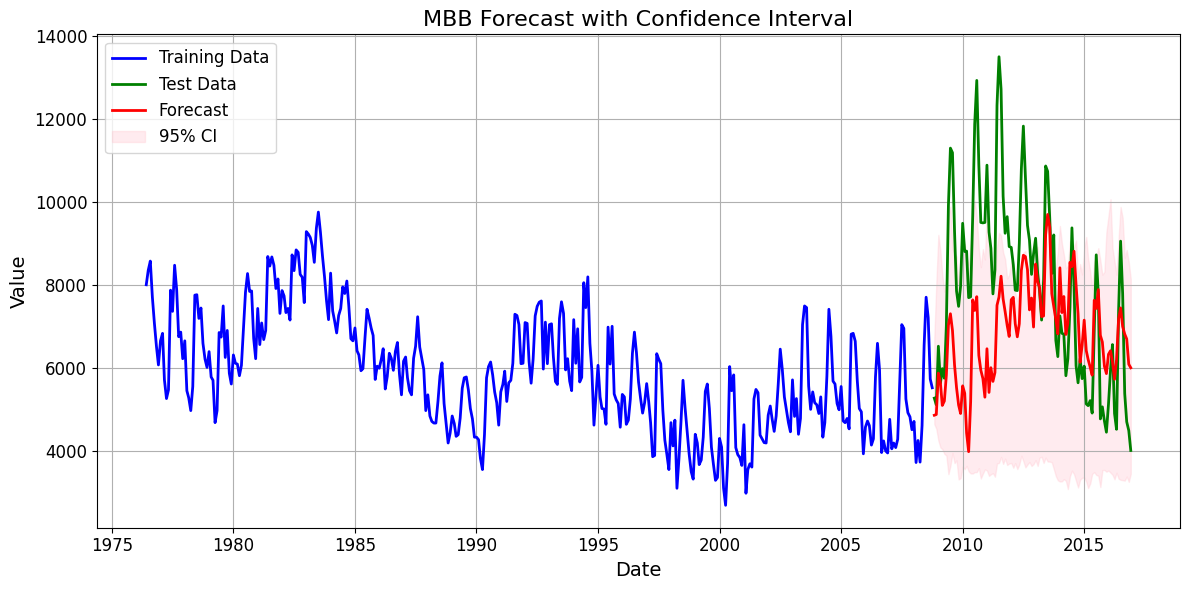

BartlettsBB

BartlettsBB Forecast Summary:
First forecast point: 4858.22 [4179.40, 7621.64]
Last forecast point: 6001.19 [3378.69, 9402.88]


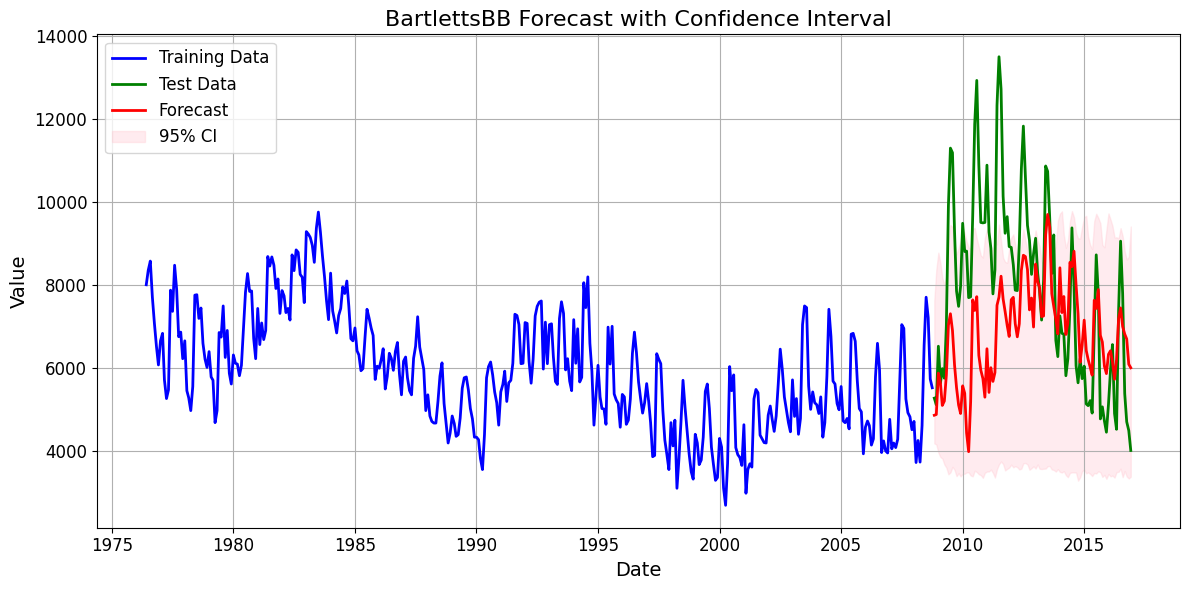

BlackmanBB

BlackmanBB Forecast Summary:
First forecast point: 4858.22 [4187.64, 7154.37]
Last forecast point: 6001.19 [3248.62, 9119.61]


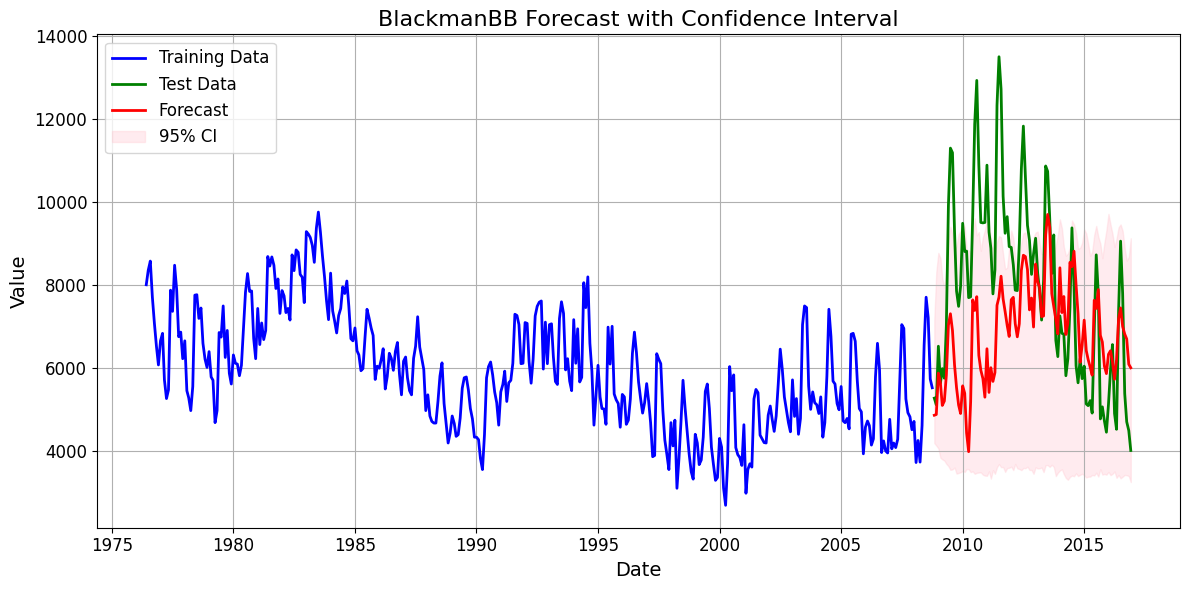

HammingBB

HammingBB Forecast Summary:
First forecast point: 4858.22 [4384.66, 7440.45]
Last forecast point: 6001.19 [3470.91, 8977.01]


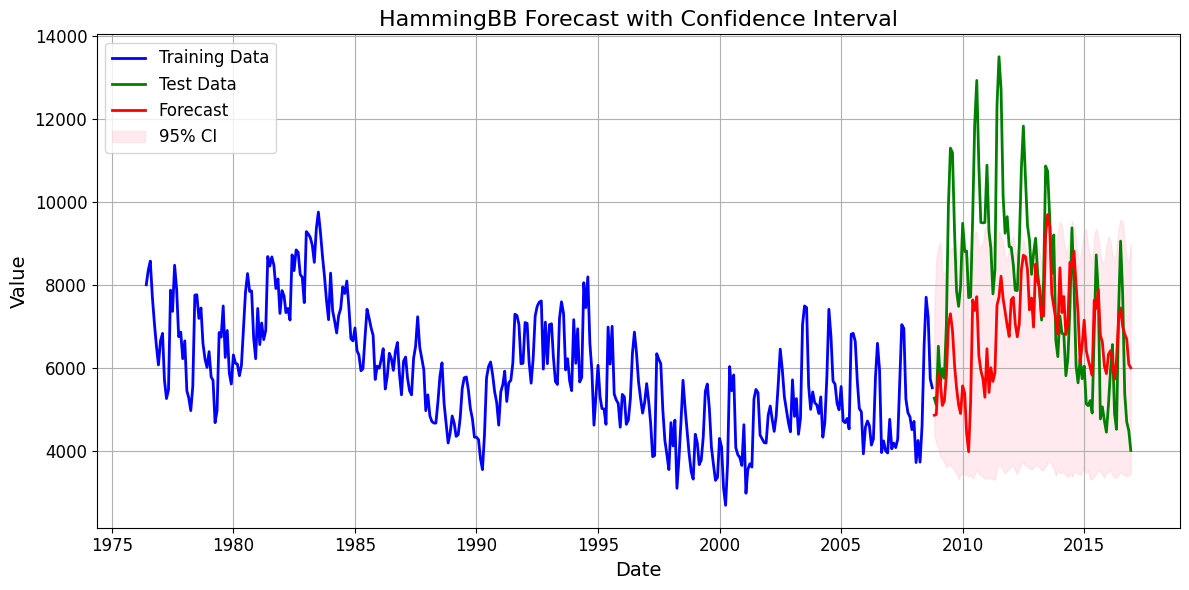

HanningBB

HanningBB Forecast Summary:
First forecast point: 4858.22 [4370.06, 7393.41]
Last forecast point: 6001.19 [3443.05, 9246.73]


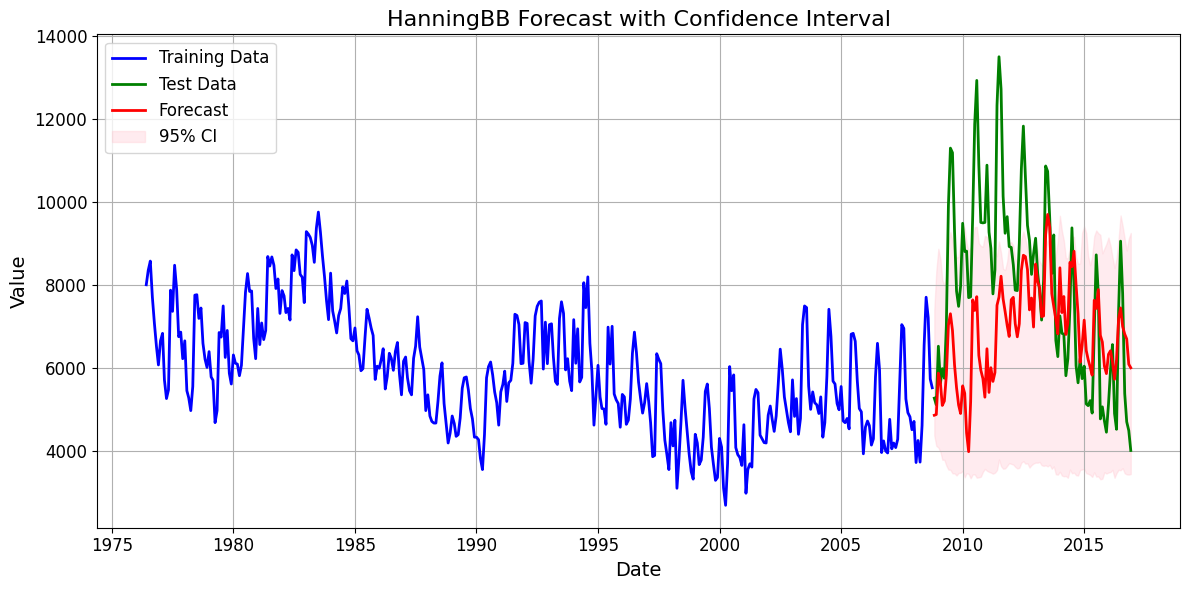

TukeyBB

TukeyBB Forecast Summary:
First forecast point: 4858.22 [4122.54, 7220.08]
Last forecast point: 6001.19 [3410.50, 9022.76]


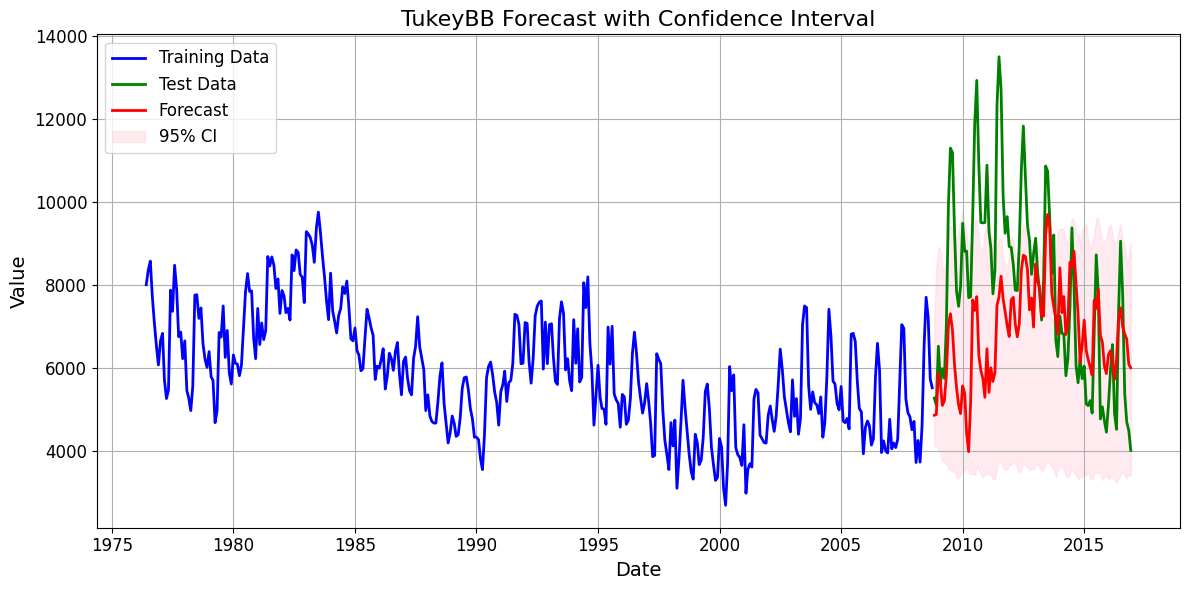

In [26]:

# Generate forecasts and plot results for each method
import warnings
warnings.filterwarnings('ignore')

for name, method in tapered_methods:
    print(name)
    samples = method.bootstrap(train.values)
    forecast, lower, upper = generate_forecast_with_ci(
        train, test, samples)
    print_forecast_summary(name, forecast, lower, upper)
    plot_forecast_with_ci(train, test, forecast, lower, upper, name)